In [1]:
%matplotlib inline
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
import common.metrics as met
import common.plots as plo
import logging
import lasagne_nn.log_parser as lp
import json
from itertools import izip

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# data handling

def get_preds(data_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if data_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth

def get_kde_dataframe(expts, data_dict, set_ratio=None, dset="drugmatrix"):
    new_df = pd.DataFrame({"prediction":[], "truth": [], "expt":[], "dset":[], "fold":[]})
    for e in expts:
        for fold in np.arange(0,5,1):
            ratio = None
            if set_ratio is not None:
                ratio = set_ratio
            if not set_ratio and "scrambled" in e:
                ratio = "1.0"
            prediction, truth = get_preds(data_dict, e, dset, fold, ratio=ratio)
            tmp = pd.DataFrame({"prediction": prediction.ravel().copy(), "truth": truth.ravel().copy(), "expt":e, "dset": dset, "fold": fold})
            if dset != "drugmatrix":
                tmp = tmp[tmp.truth.notnull()]
            new_df = new_df.append(tmp)
    
    return new_df

In [3]:
def plot_expt_kdes(df, palette_map, linspace=True, min_cutoff=5.0, max_cutoff=None, percentile_cutoffs=True,
                   n_kdes=20,kde_kws=None, figsize=(15,7), percentile_cutoff=99, 
                   min_percentile_cutoff=50, title=None, ylim=(0,0.5), xlim=(3,12), labelsize=10, titlesize=17,
                   num_legend_columns=1, legend_bbox=(1,1), legend_fontsize="small",):
    
    sns.set_context("talk")
    plt.figure(figsize=figsize)
    
    for j in range(len(palette_map)):
        curr_expt = palette_map[j][0]
        outer_tmp_df = df[df.expt == curr_expt].copy()
        outer_tmp_df[outer_tmp_df.truth.notnull()]
        
        if percentile_cutoffs:
            max_cutoff = np.percentile(outer_tmp_df.prediction, percentile_cutoff)
            min_cutoff = np.percentile(outer_tmp_df.prediction, min_percentile_cutoff)
        if linspace:
            cutoffs = np.linspace(min_cutoff, max_cutoff, n_kdes)
        else: 
            cutoffs = np.geomspace(min_cutoff, max_cutoff, n_kdes)
            
        palette_ctr = 0
        
        for i in cutoffs:
            inner_tmp_df = outer_tmp_df[outer_tmp_df.prediction >= i].copy()
            g = sns.distplot(inner_tmp_df.truth, kde=True, hist=False, 
                             kde_kws=kde_kws, color=palette_map[j][1][palette_ctr], label=curr_expt)
            sns.rugplot(a=[inner_tmp_df.truth.median()], colors=[palette_map[j][1][palette_ctr]],
                       linewidth=4.0, alpha=0.9, height=0.1)
            palette_ctr += 1
            
    ax = plt.gca()
    
    #  make pretty spines and lines
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    plt.tick_params(axis='x', which='both', bottom=True, top=False) 
    plt.tick_params(axis='y', which='both', left=True, right=False) 
    
    # axis label sizes
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
    plt.xlabel("pAC50")
    plt.ylabel("KDE")
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    # legend plotting
    handles, labels = ax.get_legend_handles_labels()
    n_lines = len(labels)
    new_handles = []
    new_labels = []
    
    for i in np.arange(-1, len(labels), n_kdes):
        if i > 0: 
            new_handles.append(handles[i])
            new_labels.append(labels[i])
        
    pylab.legend(new_handles, new_labels, loc=1, 
                 fontsize=legend_fontsize,ncol=num_legend_columns)
    
    # title plotting
    pylab.title(title, fontdict={'fontsize': titlesize,
     'verticalalignment': 'bottom',})
    
    return

In [4]:
reg_data_file = "../regression/regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    reg_data_dict = pkl.load(f)
    
class_data_file = "../classification/classification_preds_file_lookup.pkl"
with open(class_data_file, "rb") as f:
    class_data_dict = pkl.load(f)

with open("../regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)
    
expt_color_lookup = {
"NEG_RM": "NEG_RM",
"STD": "STD",
"NEG_RM_SMA": "NEG_RM_SMA",
"STD_SMA": "STD_SMA",
"scrambled_idx": "scrambled_idx",
"SEA_SMA": "SEA_SMA",
"scrambled_idx_no_SMA": "scrambled_idx_no_SMA",
"CLASSIFIER_SEA_SMA": "SEA_SMA",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "NEG_RM_SMA",
"CLASSIFIER_SMA_RATIOS": "STD_SMA",
"CLASSIFIER_scrambled_idx_LC": "scrambled_idx",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_STD": "STD", }

In [6]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_SMA_RATIOS",  "CLASSIFIER_STD", ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "STD_SMA", "STD",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

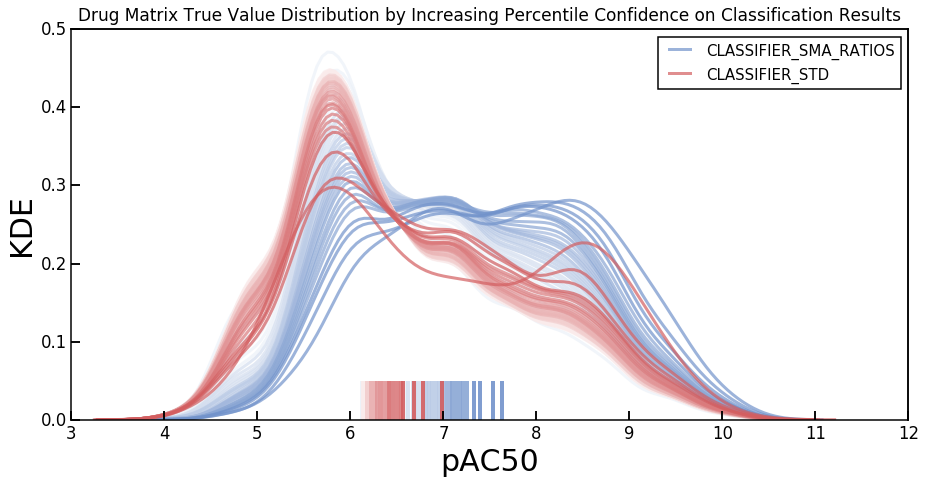

In [8]:
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Classification")
plot_expt_kdes(class_kde_df, class_palettes, linspace=True, min_cutoff=class_min, labelsize=30, titlesize=17,
               n_kdes=n_kdes, kde_kws=kde_kws, percentile_cutoff=percentile_cutoff,
               title=title) 


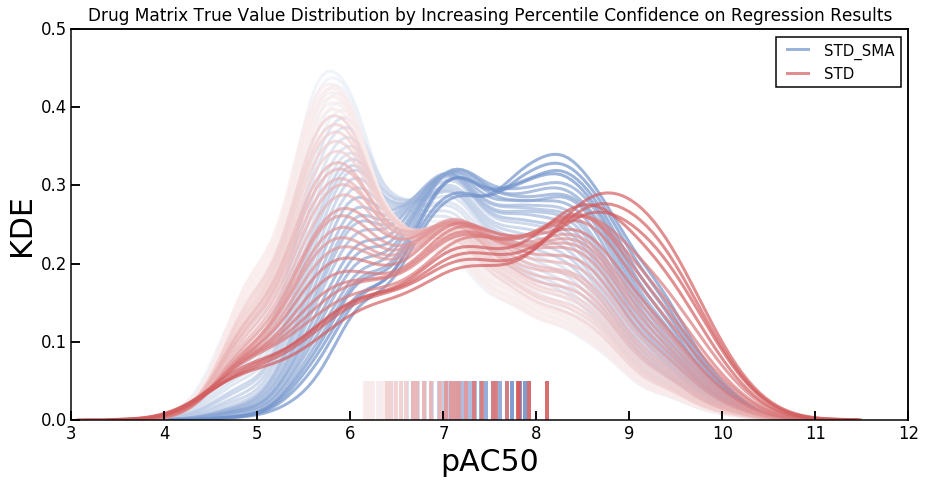

In [9]:
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Regression")

plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True, min_cutoff=reg_min, labelsize=30, titlesize=17,
               n_kdes=n_kdes, kde_kws=kde_kws, percentile_cutoff=percentile_cutoff,
               title=title) 

## What happens with the scrambled?


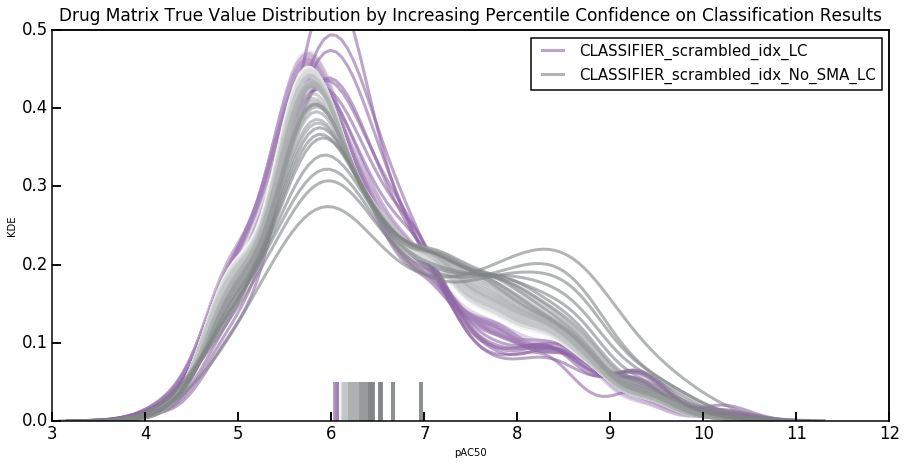

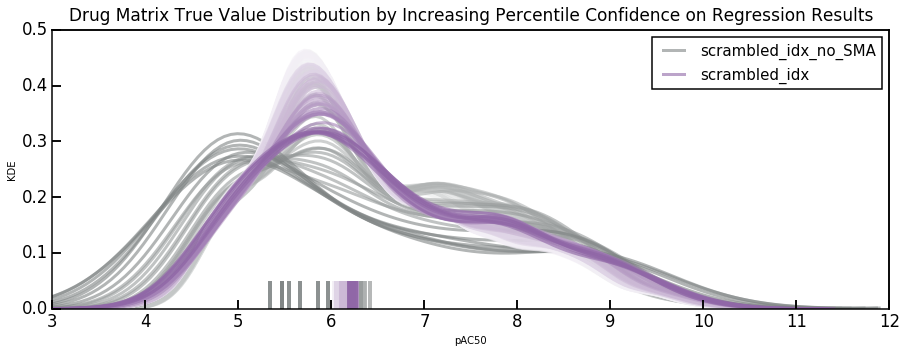

In [10]:
n_kdes=50
percentile_cutoff=99
min_percentile_cutoff = 50
kde_kws = {"linewidth":3.0, "alpha":0.6}

class_expts = [ "CLASSIFIER_scrambled_idx_LC", "CLASSIFIER_scrambled_idx_No_SMA_LC",]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "scrambled_idx_no_SMA", "scrambled_idx", ]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                   sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Classification")

plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff,
              title=title)
plt.show()

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Regression")

plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff,
              title=title) 
plt.show()

## Comparison to scrambled

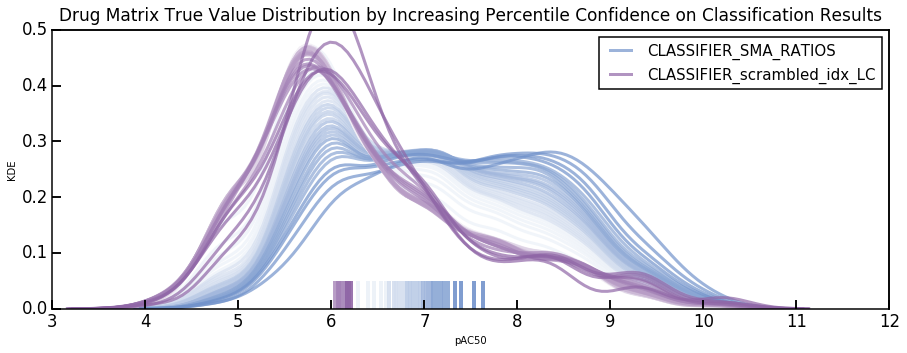

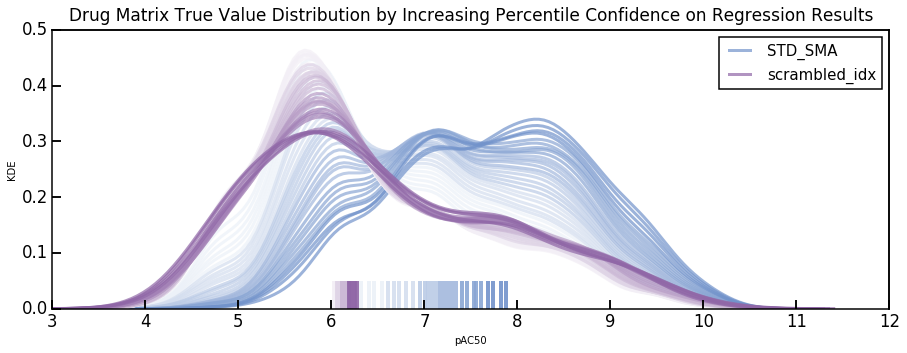

In [12]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_SMA_RATIOS",  "CLASSIFIER_scrambled_idx_LC",  ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "STD_SMA", "scrambled_idx",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Classification")

plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff, title=title) 
plt.show()
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Regression")
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff, title=title) 
plt.show()

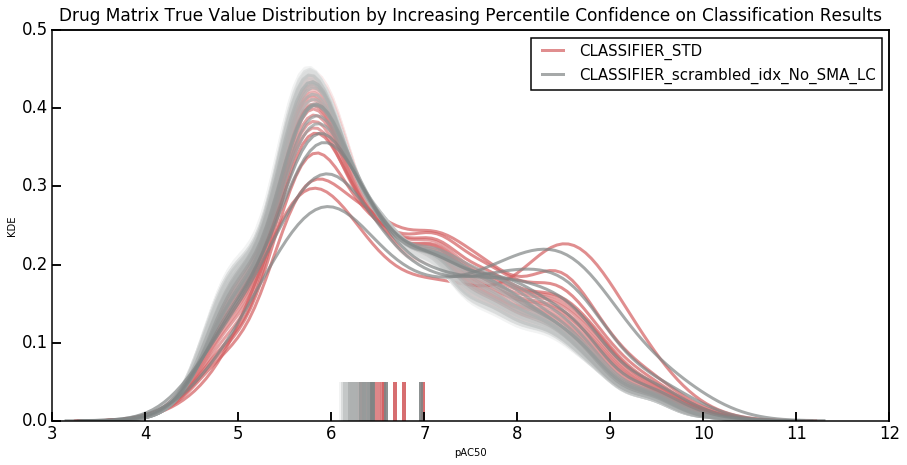

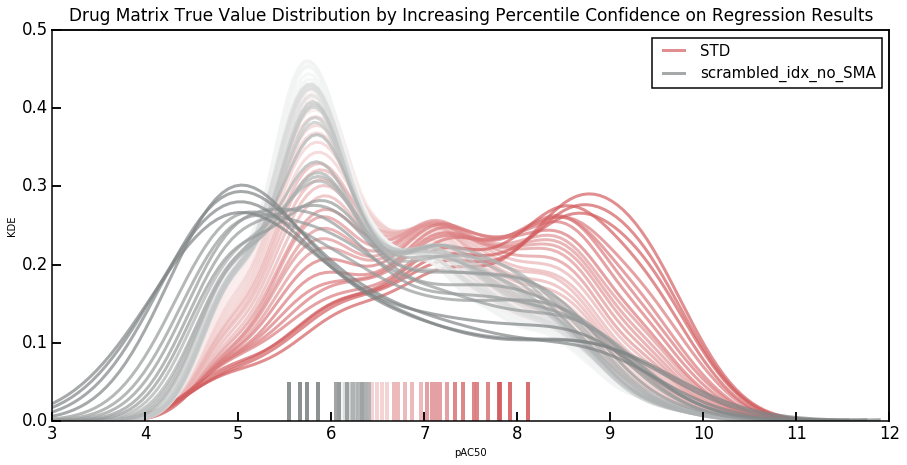

In [13]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_STD", "CLASSIFIER_scrambled_idx_No_SMA_LC",]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "STD", "scrambled_idx_no_SMA",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Classification")
plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff,
              title=title) 
plt.show()
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Drug Matrix", "Regression")
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws,  
               percentile_cutoff=percentile_cutoff,
              title=title) 
plt.show()

In [14]:
# class_expts = ["CLASSIFIER_SMA_RATIOS_LR03",  "CLASSIFIER_STD_LR03", "CLASSIFIER_scrambled_idx_LR03", "CLASSIFIER_scrambled_idx_No_SMA_LR03",]
# class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0, dset="timesplit")

# reg_expts = [ "STD_SMA", "STD", "scrambled_idx_no_SMA", "scrambled_idx",]
# reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None, dset="timesplit")

# class_kde_df.to_csv("./class_ts_kde_df.tsv", sep="\t")
# reg_kde_df.to_csv("./reg_ts_kde_df.tsv", sep="\t")

In [15]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_kde_df = pd.read_csv("./class_ts_kde_df.tsv", sep="\t")
reg_kde_df = pd.read_csv("./reg_ts_kde_df.tsv", sep="\t")

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.8}

In [16]:
new_class_expts=["CLASSIFIER_SMA_RATIOS_LR03",  "CLASSIFIER_STD_LR03",]
new_class_kde_df = class_kde_df[class_kde_df.expt.isin(new_class_expts)]
new_class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes)) for i in new_class_expts]
for i in range(len(new_class_palettes)):
    new_class_palettes[i][1].sort(reverse=True)

new_reg_expts=["STD_SMA", "STD",]
new_reg_kde_df = reg_kde_df[reg_kde_df.expt.isin(new_reg_expts)]
new_reg_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes)) for i in new_reg_expts]
for i in range(len(new_reg_palettes)):
    new_reg_palettes[i][1].sort(reverse=True)
    
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Classification")

plot_expt_kdes(new_class_kde_df, new_class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               percentile_cutoff=percentile_cutoff,
               min_percentile_cutoff=min_percentile_cutoff,
               title=title)
plt.show()

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Regression")

plot_expt_kdes(new_reg_kde_df, new_reg_palettes, 
               linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
              title=title) 
plt.show()


KeyError: 'CLASSIFIER_SMA_RATIOS_LR03'

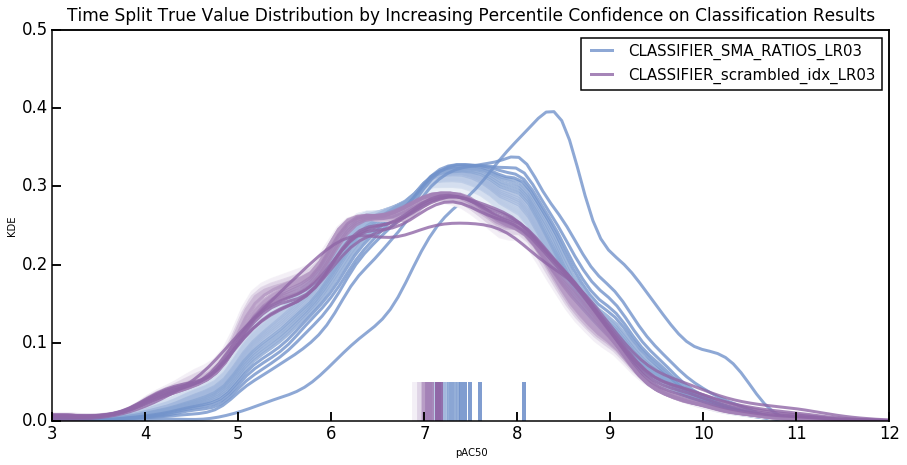

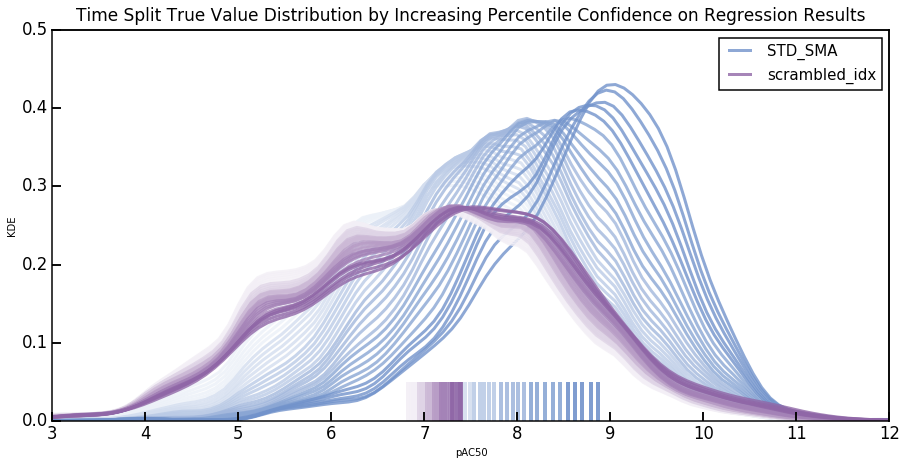

In [14]:
new_class_expts = ["CLASSIFIER_SMA_RATIOS",  "CLASSIFIER_scrambled_idx_LC
                   ",  ]
new_class_kde_df = class_kde_df[class_kde_df.expt.isin(new_class_expts)]
new_class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes)) for i in new_class_expts]
for i in range(len(new_class_palettes)):
    new_class_palettes[i][1].sort(reverse=True)

new_reg_expts = [ "STD_SMA", "scrambled_idx",]
new_reg_kde_df = reg_kde_df[reg_kde_df.expt.isin(new_reg_expts)]
new_reg_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes)) for i in new_reg_expts]
for i in range(len(new_reg_palettes)):
    new_reg_palettes[i][1].sort(reverse=True)
    
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Classification")

plot_expt_kdes(new_class_kde_df, new_class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               percentile_cutoff=percentile_cutoff,
               min_percentile_cutoff=min_percentile_cutoff,
               title=title)
plt.show()

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Regression")

plot_expt_kdes(new_reg_kde_df, new_reg_palettes, 
               linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
              title=title) 
plt.show()


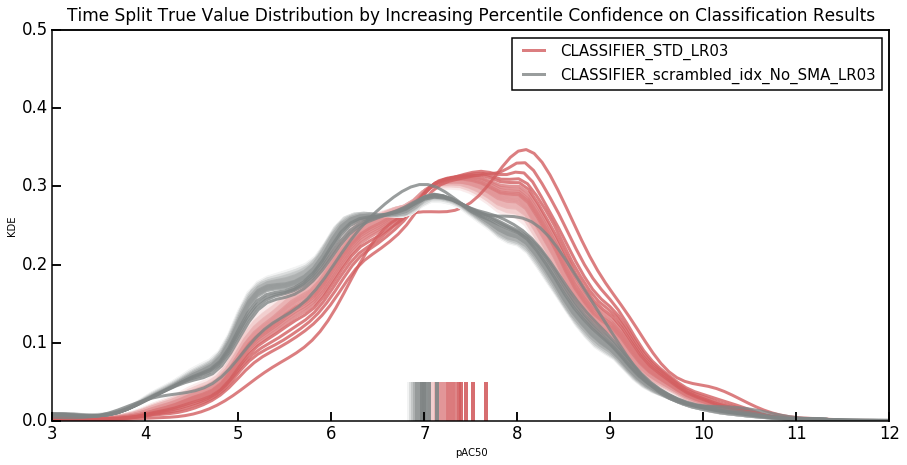

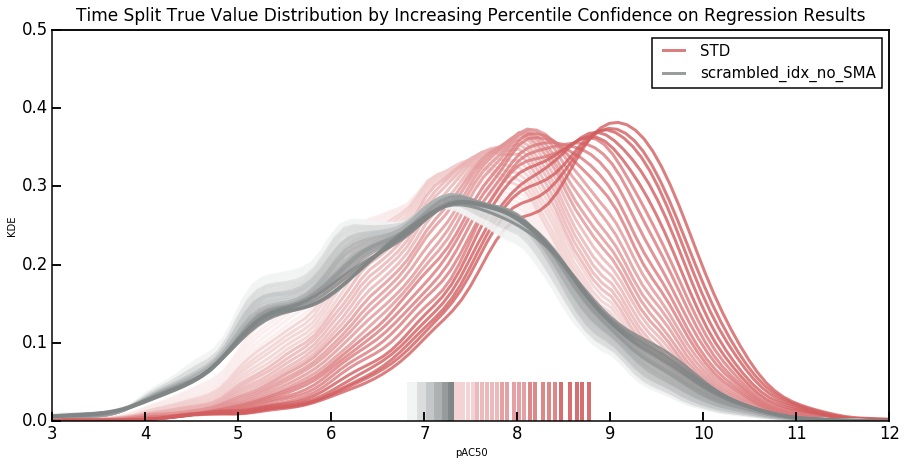

In [15]:
new_class_expts = ["CLASSIFIER_STD_LR03", "CLASSIFIER_scrambled_idx_No_SMA_LR03",]
new_class_kde_df = class_kde_df[class_kde_df.expt.isin(new_class_expts)]
new_class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes)) for i in new_class_expts]
for i in range(len(new_class_palettes)):
    new_class_palettes[i][1].sort(reverse=True)

new_reg_expts = [ "STD", "scrambled_idx_no_SMA",]
new_reg_kde_df = reg_kde_df[reg_kde_df.expt.isin(new_reg_expts)]
new_reg_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes)) for i in new_reg_expts]
for i in range(len(new_reg_palettes)):
    new_reg_palettes[i][1].sort(reverse=True)
    
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Classification")

plot_expt_kdes(new_class_kde_df, new_class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               percentile_cutoff=percentile_cutoff,
               min_percentile_cutoff=min_percentile_cutoff,
               title=title)
plt.show()

title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Regression")

plot_expt_kdes(new_reg_kde_df, new_reg_palettes, 
               linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
              title=title) 
plt.show()


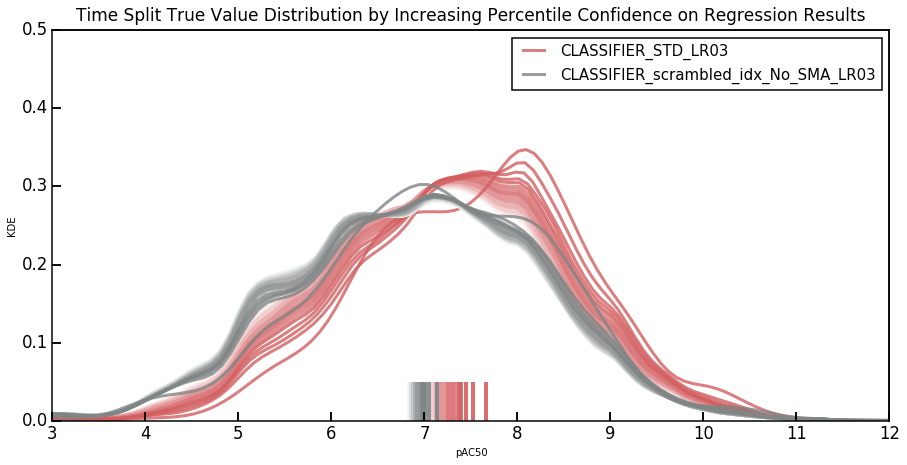

In [16]:
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Regression")

plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
               title=title) 

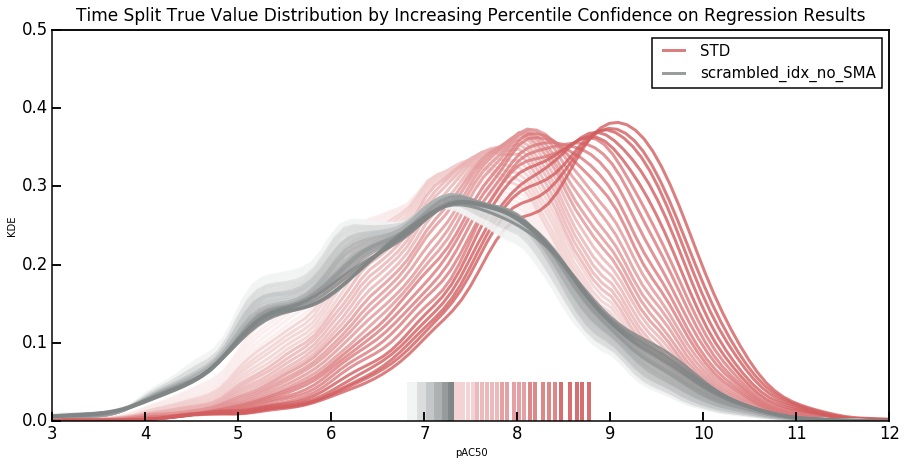

In [17]:
title="{} True Value Distribution by Increasing Percentile Confidence on {} Results".format("Time Split", "Regression")

plot_expt_kdes(reg_kde_df, reg_palettes, 
               linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               percentile_cutoff=percentile_cutoff,
              title=title) 

In [18]:
from scipy.stats import rankdata

In [48]:
def get_ranked_df_truth_vals(df):
    new_df = pd.DataFrame({"prediction":[], "truth": [], "expt":[], "dset":[], "fold":[], "rank":[]})
    for e in df.expt.unique():
        tmp = df[class_kde_df.expt == e].copy()
        tmp["rank"] = rankdata(tmp.prediction)
        new_df = pd.concat([new_df, tmp])
    return new_df

In [49]:
class_kde_df = pd.read_csv("./class_ts_kde_df.tsv", sep="\t")
new_class_expts = ["CLASSIFIER_STD_LR03", "CLASSIFIER_scrambled_idx_No_SMA_LR03",]
new_class_kde_df = class_kde_df[class_kde_df.expt.isin(new_class_expts)]

a = get_ranked_df_truth_vals(class_kde_df)
a["thresholded"] = "+"
a["thresholded"][a.truth <= 5.0] = "-"

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [50]:
tobin

array([  3.  ,   3.25,   3.5 ,   3.75,   4.  ,   4.25,   4.5 ,   4.75,
         5.  ,   5.25,   5.5 ,   5.75,   6.  ,   6.25,   6.5 ,   6.75,
         7.  ,   7.25,   7.5 ,   7.75,   8.  ,   8.25,   8.5 ,   8.75,
         9.  ,   9.25,   9.5 ,   9.75,  10.  ,  10.25,  10.5 ,  10.75,
        11.  ,  11.25,  11.5 ,  11.75,  12.  ,  12.25,  12.5 ,  12.75])

In [67]:
tobin = [0, 5.0, 9.0, 13]
a['bin'] = pd.cut(abs(a.truth), tobin, precision=0)

In [68]:
np.max(a["rank"])

484315.0

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
cpal=sns.color_palette('RdBu',n_colors=len(tobin)-1,desat=1.)
ax = sns.stripplot(x='rank', y='expt', data=a, jitter=0.4,
                   edgecolor='none', alpha=0.5, size=4, hue='bin', palette=cpal)
plt.xlim((0,484315))